## FastCampus PJT - Team 3
##### 심성식 김민수 심승현 이희상 이용기

### 라이브러리 관련 및 환경 셋업

###### 필요한 모듈 설치

In [ ]:
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install scipy
# !pip install seaborn

###### 필요한 모듈 모두 불러오기

In [1]:
import os
import time
import numpy as np
import pandas as pd
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import re
import glob
import seaborn as sns
import datetime

###### 폰트 확인

In [2]:
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
font_path = fm.findfont('AppleGothic')
if not font_path:
    print('Warning: AppleGothic font not found')
else:
    print("AppleGothic font found at ", font_path)

font_prop = fm.FontProperties(fname=font_path, size=12)


AppleGothic font found at  /System/Library/Fonts/Supplemental/AppleGothic.ttf


### 경로 설정

###### 폴더 생성 및 경로 variable 생성

In [3]:
# Creating folders and variables for data paths

dataset = "./dataset/"
GROUPED = dataset + "Grouped/"
FINAL_GROUP = dataset + "Grouped_Final/"

if not os.path.exists("./dataset"):
    os.mkdir("./dataset")

if not os.path.exists(dataset + "Grouped"):
    os.mkdir(dataset + "Grouped")

if not os.path.exists(dataset + "Grouped_Final"):
    os.mkdir(dataset + "Grouped_Final")

###### 파일 경로 불러올 딕셔너리 생성

In [4]:
# Adding up all file locations into a dictionary.

file_locations = {
    "dataset" : dataset,
    'grouped': GROUPED,
    'group_final' : FINAL_GROUP #,
    # to be added further
}

all_file_locations = {}
for key, value in file_locations.items():
    all_file_locations[key] = glob.glob(value + "*.csv")

'''

type all_file_locations["key"] to call
keys are "dataset", "grouped", "group_final", etc.; to be added further.

'''

'\n\ntype all_file_locations["key"] to call\nkeys are "dataset", "grouped", "group_final", etc.; to be added further.\n\n'

#### 준비

###### Definition 설정

In [5]:
# Local definitions - 1

def clean_course_name(course_name):
    '''
    course name 중 첫 구절이 ( 으로 시작하고, 
    ~ 로 스플릿한 구절 중 0번째 len이 7인 경우; 예시: "(220123"
    ) 이후의 course name을 return합니다.
    
    아래와 같이 사용해 주시면 편합니다.
    df["course_name"] = df["course_name"].apply(clean_course_name)

    '''
    if course_name.startswith("("):
        # Classify the date range to cleanse.
        if "~" in course_name:
            temp = course_name.split("~")[0]
            # if the value before ~ is in year format, remove the whole bracket.
            if len(temp) == 7:
                return course_name.split(")")[1]
            else:
                return course_name
        else:
            return course_name
    else:
        return course_name

In [6]:
# Local definitions - 2

def course_packages(row):
    '''
    패키지명을 return하는 코드입니다.
    
    아래와 같이 apply 해주시고 적용 희망하시는 row를 대치시켜주시면 됩니다.
    df["course_group"] = df.apply(course_packages, axis=1)
    
    '''
    # Splitting course classifier (: and -) to extract package name
    parts = re.split("[:|-]", row["course_name"])
    # Finding course names without package classifier
    if len(parts) <= 1:
        # [무료강의] as an exception, it makes more sense if we classify itself alone.
        if parts[0].startswith("[무료강의]"):
            return "[무료강의]"
        # Classify all other courses without package classifier into Other.
        return ("Other")
    # Finding course names with package classifier.
    elif len(parts) > 1:
        # Classify [kit] first, as it needs to be separated from other [ ] covered words.
        if parts[0].startswith("[kit]"):
            return "[kit]"
        # Removing (( ))
        elif parts[0].startswith("(("):
            return parts[0].split("))")[1]
        # Removing ( )
        elif parts[0].startswith("("):
            return parts[0].split(")")[1]
        # Removing [ ]
        elif parts[0].startswith("["):
            return parts[0].split("]")[1]
        else:
            return parts[0]
    else:
        return parts[0]


In [7]:
# Local definitions - 2

def coupons(df):
    '''
    coupon name을 통해 특수 형태의 쿠폰 분류,
    예외의 경우, 타 column 활용하여 쿠폰 분류
    
    아래와 같이 사용해 주시면 편합니다.
    df = coupons(df)
    
    '''
    # Find the length of DataFrame
    for i in range(len(df)):
        # Counter Set
        found = False
        # if dict key is in coupon name, insert dict value in coupon type
        if isinstance(df["coupon_name"][i], str):
            for key, value in external_coupons.items():
                if key in df["coupon_name"][i]:
                    df.at[i, "coupon_type"] = value
                    # counter
                    found = True
                    break
            else:
                for key, value in internal_coupons.items():
                    if key in df["coupon_name"][i]:
                        df.at[i, "coupon_type"] = value
                        found = True
                        break
        # if not found from the above,
        if not found:
            # first, set all remaining coupon's type as general
            if isinstance(df["coupon_name"][i], str):
                df.at[i, "coupon_type"] = "general"
            # then, find 100% discount coupon and assign it as "free"
            if df["actual_sold_price"][i] == 0.0 and df["transaction_amount"][i] == 0.0:
                df.at[i, "coupon_type"] = "free"
            # then, find % discount coupons and assign it as its percent
            if isinstance(df["coupon_discount"][i], float) and isinstance(df["coupon_name"][i], str) and "%" in df["coupon_name"][i]:
                df.at[i, "coupon_type"] = f"{df['coupon_name'][i].split('%')[0][-2:]} percent"
            else:
                continue
    return df


###### 컬럼명 영문으로 변경 - Encoding 이슈 방지

In [8]:
# Changing column names from Korean to English

df = pd.read_csv('./eda-proj-fc-purchase.csv')
df.rename(columns={"거래id":"transaction_id", "유형":"l_type", "고객id":"customer_id","코스ID":"courseID","사이트":"site", "포맷":"l_format",
                   "카테고리":"l_categories", "코스(상품) 이름":"course_name", "거래일자":"transaction_date_time","쿠폰이름":"coupon_name",
                   "판매가격":"sold_price","결제수단":"payment_method","실거래금액":"actual_sold_price","쿠폰할인액":"coupon_discount",
                   "거래금액":"transaction_amount","환불금액":"refund_amount"
                   },
          inplace=True)
df.to_csv(dataset + "rawdata_eng.csv", index=False)

###### 사전 데이터 탐색

In [9]:
df.l_categories.value_counts()

프로그래밍       51705
데이터 사이언스    26859
일러스트        15443
영상/3D       13923
업무 생산성      13916
마케팅         12896
부동산/금융      10797
디자인         10211
투자/재테크       2483
부업/창업        1094
크리에이티브          1
Name: l_categories, dtype: int64

In [10]:
grouped = df.groupby("l_categories")
df_temp = pd.DataFrame()
df_temp["count"] = grouped.size()
df_temp["home_lecture_num"] = grouped["course_name"].nunique()
df_temp["c_count"] = grouped.size() / len(df) * 100
df_temp["h_count"] = grouped["course_name"].nunique() / df["course_name"].nunique() * 100

df_temp = df_temp.sort_values(by="count", ascending=False)
df_temp

,count,home_lecture_num,c_count,h_count
l_categories,,,,
프로그래밍,51705,92,32.451923,22.604423
데이터 사이언스,26859,82,16.857677,20.147420
일러스트,15443,36,9.692584,8.845209
영상/3D,13923,51,8.738577,12.530713
업무 생산성,13916,30,8.734184,7.371007
마케팅,12896,37,8.093995,9.090909
부동산/금융,10797,33,6.776587,8.108108
디자인,10211,30,6.408792,7.371007
투자/재테크,2483,11,1.558420,2.702703


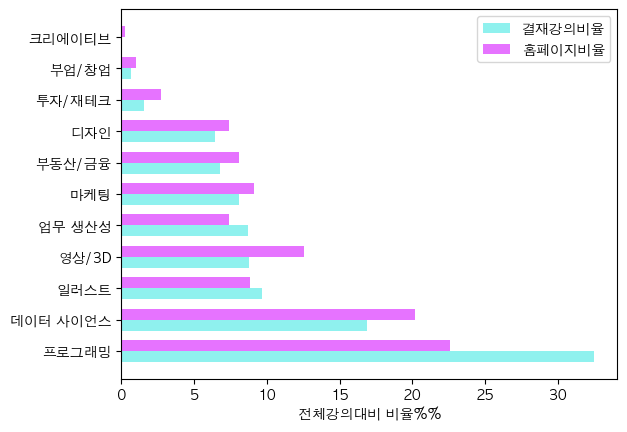

In [11]:
x_label = df_temp.index
x = np.arange(len(x_label))
y_1 = df_temp['c_count']
y_2 = df_temp['h_count']
# 넓이 지정
width = 0.35
# subplots 생성
fig, axes = plt.subplots()
# 넓이 설정
axes.barh(x - width/2, y_1, width, align='center', alpha=0.5, color=(33/255,229/255,222/255))
axes.barh(x + width/2, y_2, width, align='center', alpha=0.8, color=(224/255,80/255,255/255))
# xtick 설정
plt.yticks(x)
axes.set_yticklabels(x_label)
plt.xlabel('전체강의대비 비율%%')
plt.title('')
plt.legend(['결재강의비율', '홈페이지비율'])
plt.show()

###### 날짜/시간 데이터 변환 및 분리

In [12]:
# Converting date_time to date and time.

rawdata = pd.read_csv(dataset+"rawdata_eng.csv")

df = rawdata['transaction_date_time'].str.split(" ", n=5, expand=True)
print(df)
rawdata['FullDate'] = df[0].str.cat([df[1], df[2]], sep="")
rawdata['year'] = df[0].replace(".","")
rawdata['month'] = df[1].replace(".","")
rawdata['day'] = df[2].replace(".","")

rawdata['FullTime'] = df[3].str.cat([df[4]], sep=" ")
times = df[4].str.split(":", expand=True)
rawdata["hour"] = times[0]
rawdata["minute"] = times[1]
rawdata["second"] = times[2]
# Converting time to 24H format

rawdata["FullTime"] = rawdata["FullTime"].str.replace("오후", "PM").str.replace("오전","AM")
rawdata['FullTime'] = rawdata['FullTime'].apply(lambda x: datetime.datetime.strptime(x, '%p %I:%M:%S').strftime('%H:%M:%S'))
df = rawdata
# rawdata.to_csv(dataset + "rawdata.csv", index=False)

            0    1    2   3         4
0       2022.  12.  31.  오후  10:12:33
1       2022.  12.  30.  오후   6:12:57
2       2022.  12.  31.  오후  11:12:15
3       2022.  12.  31.  오후  11:12:03
4       2022.  12.  31.  오후  11:12:10
...       ...  ...  ...  ..       ...
159323  2022.   1.   1.  오전  12:01:08
159324  2022.   1.   1.  오전  12:01:12
159325  2022.   1.   1.  오전  12:01:21
159326  2022.   1.   2.  오전  11:01:24
159327  2022.   1.  24.  오전   4:01:00

[159328 rows x 5 columns]


###### 불필요한 데이터 처리

In [13]:
# Deleting Rows

# 크리에이티브
print("Number of rows before deletion:", len(df))
df = df[df["l_categories"] != "크리에이티브"]
print("Number of rows after deletion:", len(df))

# Format 컬럼

df = df.drop("l_format", axis=1)
df = df.drop("l_type", axis=1)

# rowdata_eng.to_csv(dataset + "columns_deleted.csv", index=False)

Number of rows before deletion: 159328
Number of rows after deletion: 159327


###### 숫자 데이터 컬럼 형 변환 (Obj -> Float)

In [14]:
# Convert dtype
df = df.replace("-",np.nan)
df["sold_price"] = df["sold_price"].astype(float)
df["actual_sold_price"] = df["actual_sold_price"].astype(float)
df["coupon_discount"] = df["coupon_discount"].astype(float)
df["transaction_amount"] = df["transaction_amount"].astype(float)
df["refund_amount"] = df["refund_amount"].astype(float)
type_converted = df
# type_converted.to_csv(dataset + "space_PLEASE.csv", index=False)

###### 코스 이름 컬럼 cleansing

In [15]:
# Removing date range in course_name

type_converted["course_name"] = type_converted["course_name"].apply(clean_course_name)
df_yes_space = type_converted
df_yes_space
df_yes_space.to_csv(dataset +"df_yes_space.csv", index = False)

###### 패키지 별 분류

In [16]:
# Grouping courses by Packages

# "The Red" had many variances, needed to cleanse the course_name once again solely for this
df_yes_space["course_name"] = df_yes_space["course_name"].apply(lambda x: x.replace(" ", "").lower())
df_no_space = df_yes_space

# Applying def course_packages.
df_no_space["course_group"] = df_no_space.apply(course_packages, axis=1)
df_no_space["course_name"] = rawdata["course_name"]
df_no_space.to_csv(dataset +"Packages_Separated.csv", index = False)

# Generating CSV file for each Package.
grouped_df = df_no_space.groupby("course_group")

for group_name, group_df in grouped_df:
    if group_name == "Other":
#     groupname = group_name.replace("/", "_")
        filename = f"{group_name}.csv"
        group_df.to_csv(GROUPED + f"{filename}", index=False)
    else:
        pass

###### 패키지 별 분류된 CSV파일 생성

In [17]:
# Some packages only had one course each, needed to re-classify them as others
for file in all_file_locations["grouped"]:
    df = pd.read_csv(file, low_memory=False)
    # print(file, file.split("/")[-1].split(".")[0] ,len(set(df["course_name"])))

df_new = pd.DataFrame()
for group_name, group_df in grouped_df:
    # We don't need to check Other.csv as we want to add more data to it
    if group_name == "Other":
        continue
    else:
        # Check if any Package has only one course
        if len(set(group_df["course_name"])) == 1:
            # There is only one course in [무료강의], but as it seemed more legit if we separate it from Others.
            if group_name == "[무료강의]":
                # Adding up [무료강의].csv to final CSV folder
                group_df.to_csv(FINAL_GROUP + "[무료강의].csv", index=False)
                pass
            else:
                # Add all packages that only has one course to df_new
                df_new = pd.concat([df_new, group_df])
                

        else:
            # Adding all the packages with multiple courses to the final CSV folder.
            filetitle = group_name.replace("/", "_")
            group_df.to_csv(FINAL_GROUP + f"{filetitle}.csv", index=False)

df_other = pd.read_csv(GROUPED + "Other.csv")
df_all = pd.concat([df_new, df_other])
df_all.to_csv(FINAL_GROUP + "Others.csv", index=False)

###### 쿠폰 분류 추가

In [18]:
internal_coupons = {"내부" : "internal",
                    "검수" : "internal",
                    "검토" : "internal",
                    "협업" : "internal",
                    "업무" : "internal",
                    "참고" : "internal",
                    "직원" : "internal",
                    "강사" : "internal",
                    "QA" : "internal",
                    "테스트" : "internal",
                    "조교" : "internal",
                    "test" : "internal",
                    "마케팅" : "internal",
                    "신해동" : "internal"
                   }
external_coupons = {"WELCOME" : "welcome",
                    "welcome" : "welcome",
                    "Welcome" : "welcome",
                     "페이백" : "payback",
                     "1+1" : "bogo",
                     "산학" : "univ",
                     "기수강자" : "return",
                     "미리보기" : "preview",
                     "100%": "free",
                     "무료" : "free"
                    }

In [19]:
df = pd.read_csv(dataset + 'Packages_Separated.csv') #추가할 데이터 부르기

df = coupons(df)
df.to_csv(dataset+"final_prep_file.csv")

###### 패키지, 쿠폰 타입 별 판매 수량

In [20]:
df_per_type_sold = pd.read_csv(dataset + "final_prep_file.csv")

grouped = df_per_type_sold.groupby("course_group")
df_temp = pd.DataFrame()
df_temp["package_count"] = grouped.size()
df_temp = df_temp.sort_values(by="package_count",ascending=False)

df_temp

,package_count
course_group,
초격차패키지,70380
올인원패키지,48043
thered,12392
Other,7516
네오아카데미,4815
편집하는여자의영상편집마스터클래스,2206
class,1793
live2d로만드는버츄얼캐릭터,1241
next.js완전정복,911


In [21]:
grouped_2 = df_per_type_sold.groupby("coupon_type")
df_temp2 = pd.DataFrame()
df_temp2["coupon_type_count"] = grouped_2.size()
df_temp2 = df_temp2.sort_values(by="coupon_type_count", ascending=False)

df_temp2

,coupon_type_count
coupon_type,
welcome,26177
bogo,16370
general,13704
payback,7729
free,4089
20 percent,3211
50 percent,2366
internal,1066
30 percent,451


###### 시각화

In [22]:
df_vis = pd.read_csv(dataset + "final_prep_file.csv")

mask1 = pd.DataFrame()
null_rows = df_vis[df_vis.isnull().any(axis=1)]
mask1 = mask1.append(null_rows)
mask1 = mask1.astype(bool) # Convert to boolean mask
mask1

/var/folders/0t/816d84452dn7h591gjkg32_m0000gn/T/ipykernel_83461/1804417383.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mask1 = mask1.append(null_rows)


,Unnamed: 0,transaction_id,customer_id,courseID,site,l_categories,course_name,transaction_date_time,coupon_name,sold_price,...,FullDate,year,month,day,FullTime,hour,minute,second,course_group,coupon_type
0,False,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159322,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
159323,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
159324,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
159325,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [23]:
pay_df = df_vis[mask1]
pay_df

,Unnamed: 0,transaction_id,customer_id,courseID,site,l_categories,course_name,transaction_date_time,coupon_name,sold_price,...,FullDate,year,month,day,FullTime,hour,minute,second,course_group,coupon_type
0,NaN,2417084,20053.0,209016,FASTCAMPUS,업무 생산성,올인원 패키지 : 김왼손의 파이썬 업무자동화 유치원,2022. 12. 31. 오후 10:12:33,NaN,189000.0,...,2022.12.31.,2022.0,12.0,31.0,22:12:33,10,12,33.0,올인원패키지,NaN
1,1.0,2415408,58309.0,210664,FASTCAMPUS,부동산/금융,초격차 패키지 : 한 번에 끝내는 부동산 금융(PF) 실무,2022. 12. 30. 오후 6:12:57,NaN,501000.0,...,2022.12.30.,2022.0,12.0,30.0,18:12:57,6,12,57.0,초격차패키지,NaN
2,2.0,2413897,18075.0,211782,FASTCAMPUS,영상/3D,편집하는여자의 영상편집 마스터클래스 - 제 6강 다양한 효과를 응용하여 애프터이펙트...,2022. 12. 31. 오후 11:12:15,NaN,549000.0,...,2022.12.31.,2022.0,12.0,31.0,23:12:15,11,12,15.0,편집하는여자의영상편집마스터클래스,NaN
3,3.0,2413891,41898.0,213450,FASTCAMPUS,프로그래밍,초격차 패키지 : 35개 프로젝트로 배우는 Android 앱 개발 feat. Jet...,2022. 12. 31. 오후 11:12:03,[WELCOME] 프로그래밍 3만원할인,165000.0,...,2022.12.31.,2022.0,12.0,31.0,23:12:03,11,12,3.0,초격차패키지,welcome
4,4.0,2413887,94328.0,210773,FASTCAMPUS,프로그래밍,"초격차 패키지 : 개발자 취업 합격 패스 With 코딩테스트, 기술면접",2022. 12. 31. 오후 11:12:10,NaN,239000.0,...,2022.12.31.,2022.0,12.0,31.0,23:12:10,11,12,10.0,초격차패키지,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159322,159322.0,1551424,39658.0,204491,FASTCAMPUS,부업/창업,올인원 패키지 : 제 2의 월급을 만들어주는 직장인 스몰비즈니스 가이드,2022. 1. 1. 오전 12:01:08,[NEW22] 온라인 강의 1만원 즉시 추가 할인 쿠폰,217000.0,...,2022.1.1.,2022.0,1.0,1.0,00:01:08,12,1,8.0,올인원패키지,general
159323,159323.0,1551410,95136.0,206811,FASTCAMPUS,영상/3D,[Kit] 닷밀의 미디어아트 그래픽 클래스 : 모션그래픽 뉴패러다임 Creative...,2022. 1. 1. 오전 12:01:12,NaN,385000.0,...,2022.1.1.,2022.0,1.0,1.0,00:01:12,12,1,12.0,[kit],NaN
159324,159324.0,1551361,12764.0,202927,FASTCAMPUS,데이터 사이언스,올인원 패키지 : 파이썬을 활용한 데이터 전처리 Level UP,2022. 1. 1. 오전 12:01:21,[WELCOME] 패캠은 처음이지? 3만원 할인쿠폰,166000.0,...,2022.1.1.,2022.0,1.0,1.0,00:01:21,12,1,21.0,올인원패키지,welcome
159325,159325.0,1545070,19606.0,208104,FASTCAMPUS,업무 생산성,올인원 패키지 : 100억을 움직이는 50가지 PPT 디자인 원칙,2022. 1. 2. 오전 11:01:24,NaN,289000.0,...,2022.1.2.,2022.0,1.0,2.0,11:01:24,11,1,24.0,올인원패키지,NaN


In [24]:
# 쿠폰 발급은 언제가 가장 많이 됨? 
use_coupon = pay_df[~pay_df["coupon_discount"].isna()]
use_coupon

,Unnamed: 0,transaction_id,customer_id,courseID,site,l_categories,course_name,transaction_date_time,coupon_name,sold_price,...,FullDate,year,month,day,FullTime,hour,minute,second,course_group,coupon_type
3,3.0,2413891,41898.0,213450,FASTCAMPUS,프로그래밍,초격차 패키지 : 35개 프로젝트로 배우는 Android 앱 개발 feat. Jet...,2022. 12. 31. 오후 11:12:03,[WELCOME] 프로그래밍 3만원할인,165000.0,...,2022.12.31.,2022.0,12.0,31.0,23:12:03,11,12,3.0,초격차패키지,welcome
7,7.0,2413876,86273.0,214558,FASTCAMPUS,프로그래밍,[Kit] 입문자를 위한 풀스택 웹 개발 Kit : 기획부터 프로젝트까지,2022. 12. 31. 오후 11:12:54,[20% 할인] 입문자를 위한 풀스택 웹 개발 Kit : 기획부터 프로젝트까지 기수...,195000.0,...,2022.12.31.,2022.0,12.0,31.0,23:12:54,11,12,54.0,[kit],return
9,9.0,2413869,21825.0,213315,FASTCAMPUS,일러스트,네오아카데미 : 킨티의 58개의 예제를 통해 배우는 캐주얼 캐릭터 완전판,2022. 12. 31. 오후 11:12:51,[WELCOME] 디자인 3만원할인,188000.0,...,2022.12.31.,2022.0,12.0,31.0,23:12:51,11,12,51.0,네오아카데미,welcome
18,18.0,2413830,96806.0,213924,FASTCAMPUS,프로그래밍,초격차 패키지 : 한 번에 끝내는 AWS 기반 아키텍처 설계와 DevOps,2022. 12. 31. 오후 11:12:36,[20% 할인 쿠폰] [한 번에 끝내는 AWS 기반 아키텍처 설계와 DevOps 초...,190000.0,...,2022.12.31.,2022.0,12.0,31.0,23:12:36,11,12,36.0,초격차패키지,20 percent
21,21.0,2413821,60037.0,205548,FASTCAMPUS,데이터 사이언스,초격차 패키지 : 한 번에 끝내는 데이터 분석,2022. 12. 31. 오후 11:12:27,[100% 쿠폰] 디마즈 1기 강의 100% 수강권,183000.0,...,2022.12.31.,2022.0,12.0,31.0,23:12:27,11,12,27.0,초격차패키지,free
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159316,159316.0,1551467,73642.0,204013,FASTCAMPUS,디자인,올인원 패키지 : 완전정복 시각디자인 기초,2022. 1. 1. 오전 12:01:53,[WELCOME] 처음이라면 누구나 디자인 5만원 할인,249000.0,...,2022.1.1.,2022.0,1.0,1.0,00:01:53,12,1,53.0,올인원패키지,welcome
159319,159319.0,1551445,78593.0,206181,FASTCAMPUS,일러스트,올인원 패키지 : 리마의 로맨스판타지 웹소설 일러스트,2022. 1. 1. 오전 12:01:40,[WELCOME] 처음이라면 누구나 디자인 5만원 할인,249000.0,...,2022.1.1.,2022.0,1.0,1.0,00:01:40,12,1,40.0,올인원패키지,welcome
159320,159320.0,1551434,82199.0,204871,FASTCAMPUS,일러스트,올인원 패키지 : star741의 캐주얼 일러스트 드로잉,2022. 1. 1. 오전 12:01:33,[NEW22] 온라인 강의 1만원 즉시 추가 할인 쿠폰,239000.0,...,2022.1.1.,2022.0,1.0,1.0,00:01:33,12,1,33.0,올인원패키지,general
159322,159322.0,1551424,39658.0,204491,FASTCAMPUS,부업/창업,올인원 패키지 : 제 2의 월급을 만들어주는 직장인 스몰비즈니스 가이드,2022. 1. 1. 오전 12:01:08,[NEW22] 온라인 강의 1만원 즉시 추가 할인 쿠폰,217000.0,...,2022.1.1.,2022.0,1.0,1.0,00:01:08,12,1,8.0,올인원패키지,general


/var/folders/0t/816d84452dn7h591gjkg32_m0000gn/T/ipykernel_83461/27192624.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.lineplot(x = np.arange(0,12) , y = [pay_df.groupby('month').sum().reset_index()['actual_sold_price'].mean()] * 12  ,\
/var/folders/0t/816d84452dn7h591gjkg32_m0000gn/T/ipykernel_83461/27192624.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.barplot(data = pay_df.groupby('month').sum().reset_index() , x = "month" , y = 'actual_sold_price')
/var/folders/0t/816d84452dn7h591gjkg32_m0000gn/T/ipykernel_83461/27192624.py:18: FutureWarning: The default value of numeric_only in DataF

<Axes: title={'center': '[월별] 쿠폰 할인 총 금액'}, xlabel='month', ylabel='coupon_discount'>

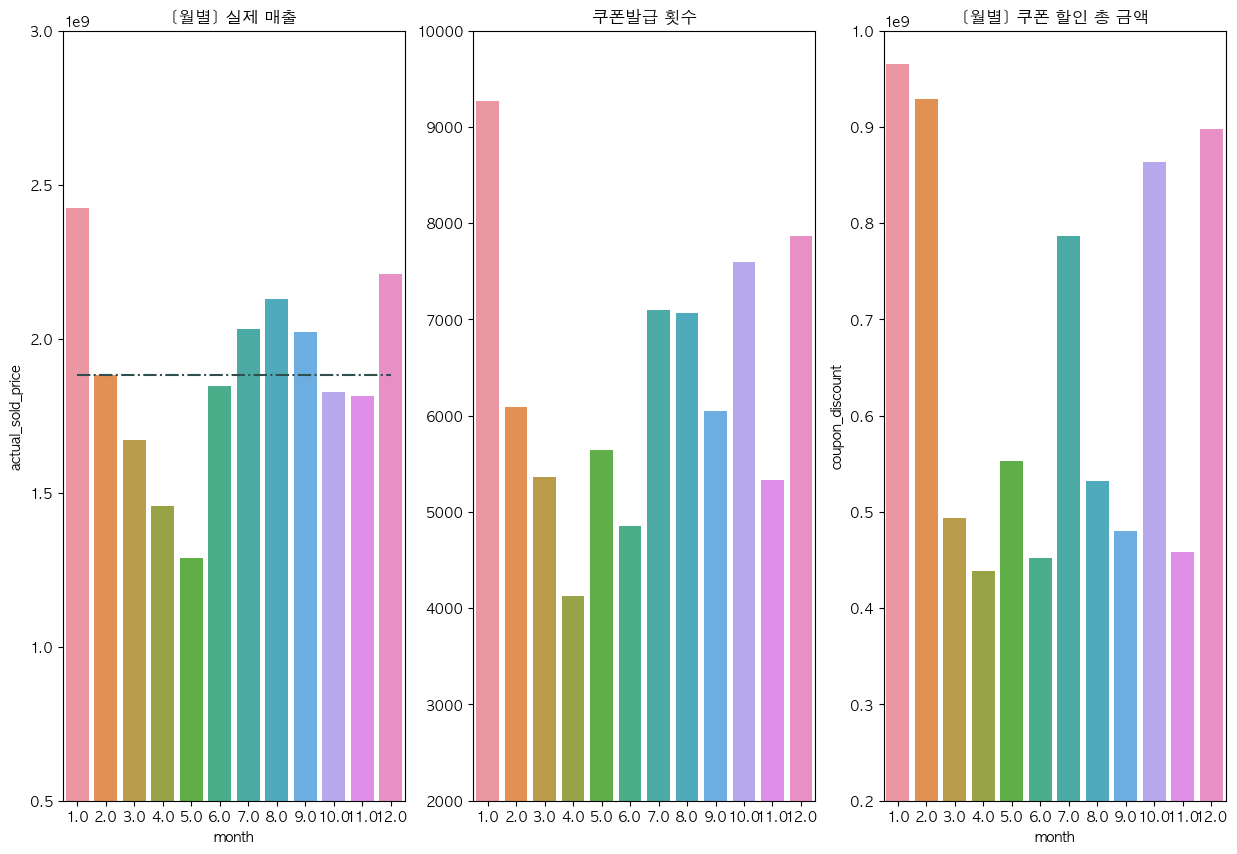

In [25]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.title("[월별] 실제 매출")
plt.ylim(0.5e9,3.0e9)
sns.lineplot(x = np.arange(0,12) , y = [pay_df.groupby('month').sum().reset_index()['actual_sold_price'].mean()] * 12  ,\
    color = "darkslategray", linestyle = "dashdot")
sns.barplot(data = pay_df.groupby('month').sum().reset_index() , x = "month" , y = 'actual_sold_price')

plt.subplot(1,3,2)
plt.title("쿠폰발급 횟수")
plt.ylim(2000,10000)
sns.barplot( x = use_coupon["month"].value_counts().index, y = use_coupon["month"].value_counts().values)


plt.subplot(1,3,3)
plt.title("[월별] 쿠폰 할인 총 금액")
plt.ylim(0.2e9,1.0e9)
sns.barplot(data = df.groupby('month').sum().reset_index() , x = "month" , y = 'coupon_discount')


/var/folders/0t/816d84452dn7h591gjkg32_m0000gn/T/ipykernel_83461/1301933173.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.lineplot(data = pay_df.groupby('month').sum().reset_index() , x = pay_df.groupby('month').sum().reset_index().index, y = 'actual_sold_price',\
/var/folders/0t/816d84452dn7h591gjkg32_m0000gn/T/ipykernel_83461/1301933173.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.lineplot(data = pay_df.groupby('month').sum().reset_index() , x = pay_df.groupby('month').sum().reset_index().index, y = 'actual_sold_price',\
/var/folders/0t/816d84452dn7h591gjkg32_m0000gn/T/ipykernel_83461/1

<Axes: title={'center': '[월별] 실제 매출'}, xlabel='month', ylabel='actual_sold_price'>

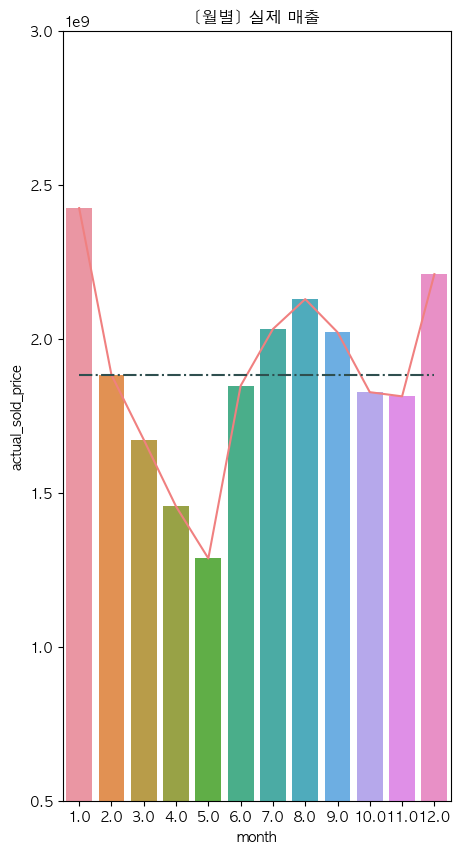

In [26]:

plt.figure(figsize=(5,10))
plt.title("[월별] 실제 매출")
plt.ylim(0.5e9,3.0e9)
sns.lineplot(data = pay_df.groupby('month').sum().reset_index() , x = pay_df.groupby('month').sum().reset_index().index, y = 'actual_sold_price',\
    color = "lightcoral" )
sns.lineplot(x = np.arange(0,12) , y = [pay_df.groupby('month').sum().reset_index()['actual_sold_price'].mean()] * 12  ,\
    color = "darkslategray", linestyle = "dashdot")
sns.barplot(data = pay_df.groupby('month').sum().reset_index() , x = "month" , y = 'actual_sold_price')

In [29]:
# 2022년 들어 프로그래밍을 구매한 이후 다른 강의를 구매한 수/비율
from datetime import datetime
from tqdm import tqdm
answer = []

# 시간별 정렬하기 위한 데이터 처리 
# for i in tqdm(range(len(pay_df))):
#   str_time = datetime(2022, pay_df.iloc[i]["month"], pay_df.iloc[i]["day"],\
#                       pay_df.iloc[i]["hour"],pay_df.iloc[i]["minute"],pay_df.iloc[i]["second"]).isoformat()
#   answer.append(str_time)
    
for i in tqdm(range(len(pay_df))):
    month = int(pay_df.iloc[i]["month"])
    day = int(pay_df.iloc[i]["day"])
    hour = int(pay_df.iloc[i]["hour"])
    minute = int(pay_df.iloc[i]["minute"])
    second = int(pay_df.iloc[i]["second"]) if not pd.isna(pay_df.iloc[i]["second"]) else 0
    str_time = datetime(2022, month, day, hour, minute, second).isoformat()
    answer.append(str_time)

100%|█████████████████████████████████| 159327/159327 [00:27<00:00, 5719.67it/s]


In [30]:
pay_df["FullTime"] = answer
# 시간별 정렬 
# duplicate시 가장 시간이 빠른 정보만 남음 > 2022년 첫 구매는 무엇을 하였는가?
time_sort_df = pay_df.sort_values("FullTime")


In [31]:
first_pay_time_sort = time_sort_df.drop_duplicates("customer_id")

In [38]:
first_count

[16378, 11342, 7696, 6256, 5391, 6074, 6419, 5125, 4292, 3875, 3177, 3590]

In [33]:
first_pay_mask = time_sort_df.duplicated("customer_id")

In [34]:
remove_first_pay_user = time_sort_df[first_pay_mask]

In [35]:
first_count = []
for i in range(1,13):
    first_count.append(len(first_pay_time_sort[first_pay_time_sort["month"] == i][["customer_id"]].drop_duplicates()))

In [36]:
remove_count = []
for i in range(1,13):
    remove_count.append(len(remove_first_pay_user[remove_first_pay_user["month"] == i][["customer_id"]].drop_duplicates()) )

([<matplotlib.axis.XTick at 0x174d81e70>,
 [Text(0, 0, '1월'),
  Text(1, 0, '2월'),
  Text(2, 0, '3월'),
  Text(3, 0, '4월'),
  Text(4, 0, '5월'),
  Text(5, 0, '6월'),
  Text(6, 0, '7월'),
  Text(7, 0, '8월'),
  Text(8, 0, '9월'),
  Text(9, 0, '10월'),
  Text(10, 0, '11월'),
  Text(11, 0, '12월')])

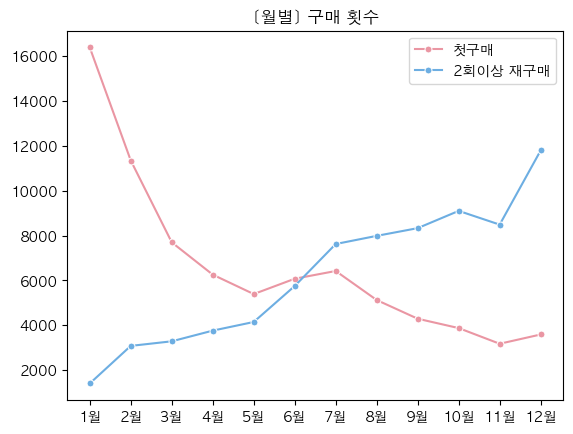

In [37]:
plt.title("[월별] 구매 횟수")
sns.lineplot(data = first_count, marker = "o" , color = "#ea96a3",label = "첫구매",markersize=5)
sns.lineplot(data = remove_count, marker = "o", color = "#6daee2", label = "2회이상 재구매",markersize=5)
# g.set_xticklabels(['1','2','3','4','5','6','7','8','9','10','11','12'])
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11] , ['1월','2월','3월','4월','5월','6월','7월','8월','9월','10월','11월','12월'])